### Imports

In [2]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib.backends.backend_pdf import PdfPages
import math
from matplotlib.lines import Line2D
import umap.umap_ as umap
from combat.pycombat import pycombat

### Read clustering dataframes (K=silhouette based analysis and K=number of cohorts)

In [25]:
gmm_cohort_cluster = pd.read_csv("../results/umap/umap_clustering_dfs/cohorts_k/gmm_cutoffs_cohorts_cluster.csv", index_col=0)
km_cohort_cluster = pd.read_csv("../results/umap/umap_clustering_dfs/cohorts_k/km_cutoffs_cohorts_cluster.csv", index_col=0)
gmm_silhouette_cluster = pd.read_csv("../results/umap/umap_clustering_dfs/silhouette_k/gmm_cutoffs_silhouette_cluster.csv", index_col=0)
km_silhouette_cluster = pd.read_csv("../results/umap/umap_clustering_dfs/silhouette_k/km_cutoffs_silhouette_cluster.csv", index_col=0)

In [26]:
# add the clustered column from silhouette approach 
gmm_cohort_cluster['Cluster_silhouette'] = gmm_silhouette_cluster['Cluster']
km_cohort_cluster['Cluster_silhouette'] = km_silhouette_cluster['Cluster']

In [27]:
umap_dfs = dict()
umap_dfs['GMM'] = gmm_cohort_cluster
umap_dfs['K-Means'] = km_cohort_cluster

In [28]:
umap_dfs['GMM'].head()

,APOE_0,APOE_1,APOE_2,Cortical White Matter Volume,Left Caudal Anterior Cingulate Mean Cortical Thickness,Left Caudal Middle Frontal Mean Cortical Thickness,Left Cuneus Mean Cortical Thickness,Left Fusiform Mean Cortical Thickness,Left Hippocampus Volume,Left Inferiorparietal Mean Cortical Thickness,...,Right Supramarginal Gray Matter Volume,Right Supramarginal Mean Cortical Thickness,Right Transverse Temporal Grey Matter Volume,Right Transverse Temporal Mean Cortical Thickness,Third Ventricle Volume,ATN,Cohort,Cohort_number,Cluster,Cluster_silhouette
0,1,0,0,529614.559202,2.803507,2.350412,1.844182,2.844034,3833.180181,2.532128,...,8318.204123,2.452891,1042.573251,2.290788,922.094185,A-T-N-,ADNI,0.0,5,1
1,1,0,0,411125.456674,2.417404,1.929103,1.619870,2.334173,3025.389642,2.030625,...,6289.481943,1.850141,518.068852,1.957553,1772.106621,A-T-N-,ADNI,0.0,4,0
2,1,0,0,455027.937947,2.638813,2.280966,1.388794,2.458860,3258.545021,2.085374,...,8367.736560,2.292158,750.061182,1.605682,2315.590254,A-T-N-,ADNI,0.0,2,0
3,1,0,0,573639.432524,2.285430,2.086515,1.636778,2.299606,4239.654603,2.106179,...,11626.338627,2.153238,1252.150863,1.963033,2368.022812,A-T-N-,ADNI,0.0,0,1
4,1,0,0,468940.967440,2.500296,2.243927,2.009880,2.387258,4029.195766,2.343791,...,9145.501219,2.330045,899.119056,2.079227,1795.297944,A-T-N-,ADNI,0.0,2,0


In [19]:
print(sns.color_palette('tab10').as_hex()[:])
sns.color_palette('tab10')

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [37]:
list(umap_dfs['GMM'].ATN.unique())

['A-T-N-', 'A+T-N-', 'A+T+N+', 'A-T+N+', 'A+T+N-', 'A+T-N+', 'A-T-N+']

In [42]:
embedded_dfs = {}

for i in umap_dfs:
    embedded_dfs[i] = {x:pd.DataFrame() for x in list(umap_dfs[i].ATN.unique())}

In [78]:
embedded_dfs['GMM']['A-T-N-'].shape

(413, 2)

In [44]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def embed_data(dfs_dict, list_cohort):
    """"""
    
    for met in dfs_dict:
        df = dfs_dict[met]
        
        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedded_dfs[met][atn_] = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(
                ['Cohort', 'ATN', 'Cohort_number', 'Cluster', 'Cluster_silhouette'])])

In [46]:
embed_data(umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

In [91]:
def plot_result(embeddings, dfs_dict, list_cohort, k):
    """"""
    
    color_cohorts = {'ADNI': '#1f77b4', 'NACC': '#d62728', 'JADNI': '#9467bd', 'DOD-ADNI': '#8c564b', 
                     'ARWIBO': '#2ca02c', 'EDSD': '#ff7f0e', 'PharmaCog': '#e377c2'}
    
    for met in embeddings:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(7, 3 * len(df['ATN'].unique())))
        
        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
#             embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN', 'Cohort_number', 'Cluster'])], 
#                     y=df.loc[df['ATN']==atn_]['Cluster'])

            embedding = embeddings[met][atn_] 

            scatter = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], ax=axes[ind], linewidth=0, 
                                      s=40, style=df.loc[df['ATN']==atn_][k], 
                                      hue=df.loc[df['ATN']==atn_]['Cohort'], alpha=0.7, palette=color_cohorts, 
                                     legend=False)
            
            plt.setp(axes[ind], xticks=[], yticks=[])

#             h, l = axes[ind].get_legend_handles_labels()
#             # dividing the legend elements into two legend 
#             axes[ind].add_artist(axes[ind].legend(handles=h[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
#                                                   labels=l[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
#                                                   fontsize=8, markerscale=1.5, loc='upper right', 
#                                                   ncol=len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1, bbox_to_anchor=(1.04,1)))
#             axes[ind].add_artist(axes[ind].legend(handles=h[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
#                                                   labels=l[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
#                                                   fontsize=8, markerscale=1.5, loc='center', 
#                                                   ncol=len(l)-len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1))
         
            axes[ind].set_title(f'{atn_}', fontsize=15)
            fig.suptitle(f'{met}', fontsize=17, fontweight='bold')
            fig.subplots_adjust(top=0.95)
            
# #             plt.savefig(f"../results/umap/paper_plots/{met}.png", dpi=300, bbox_inches='tight')

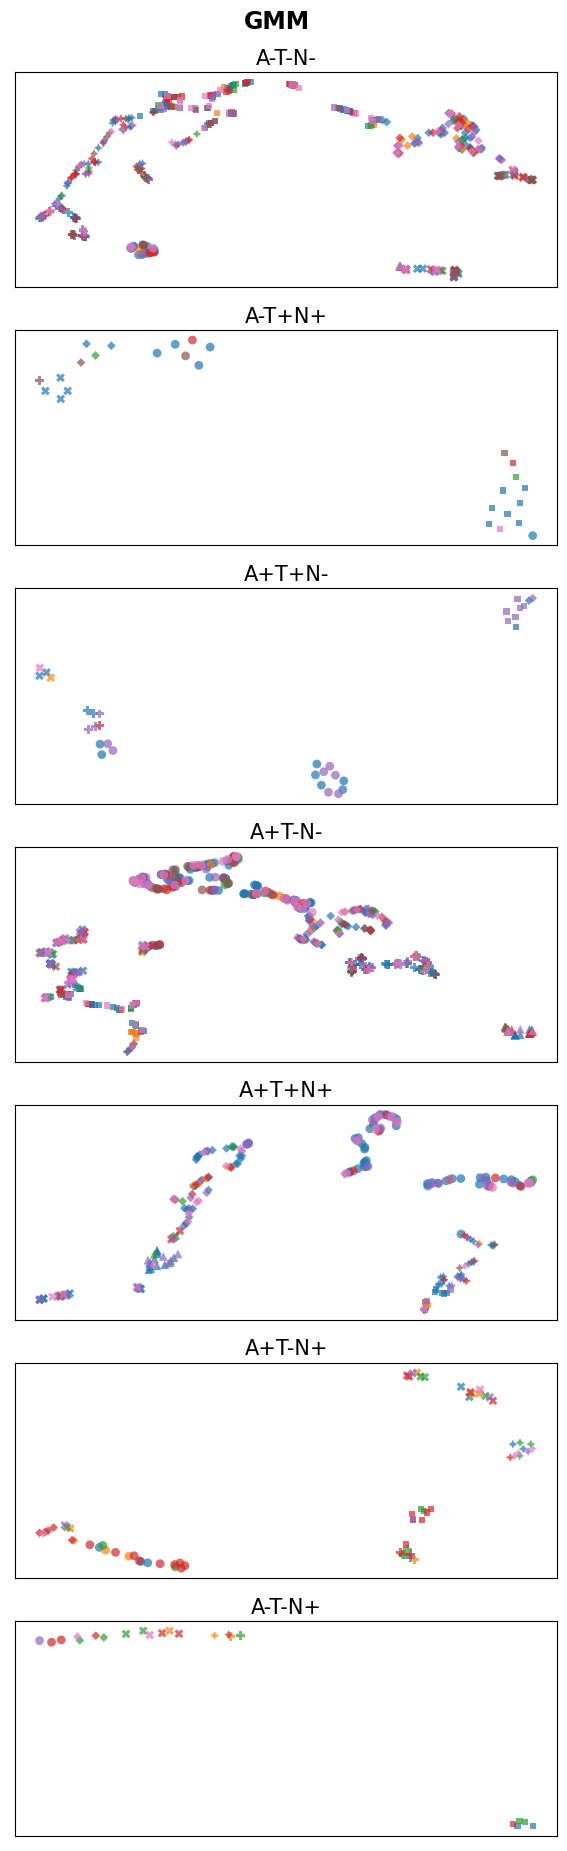

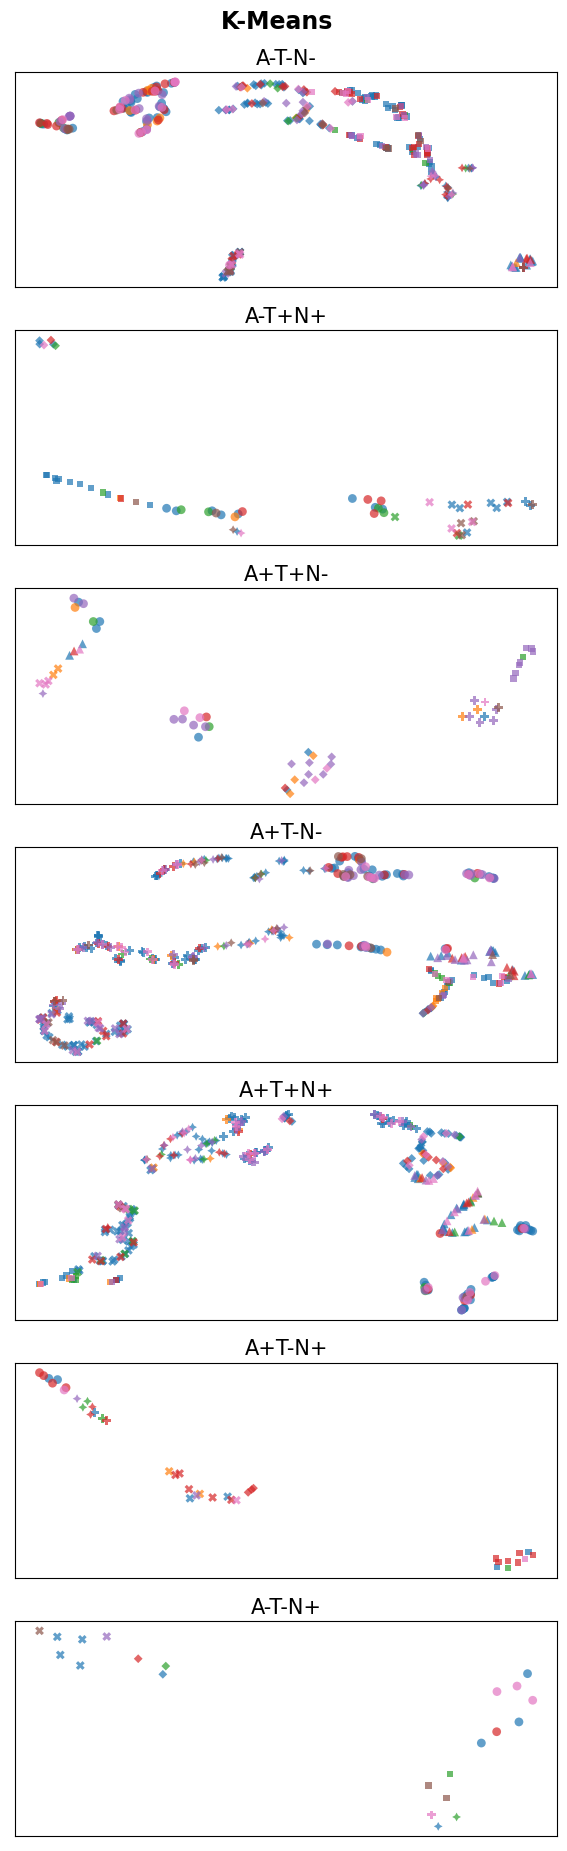

In [92]:
plot_result(embedded_dfs, umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'], 'Cluster')

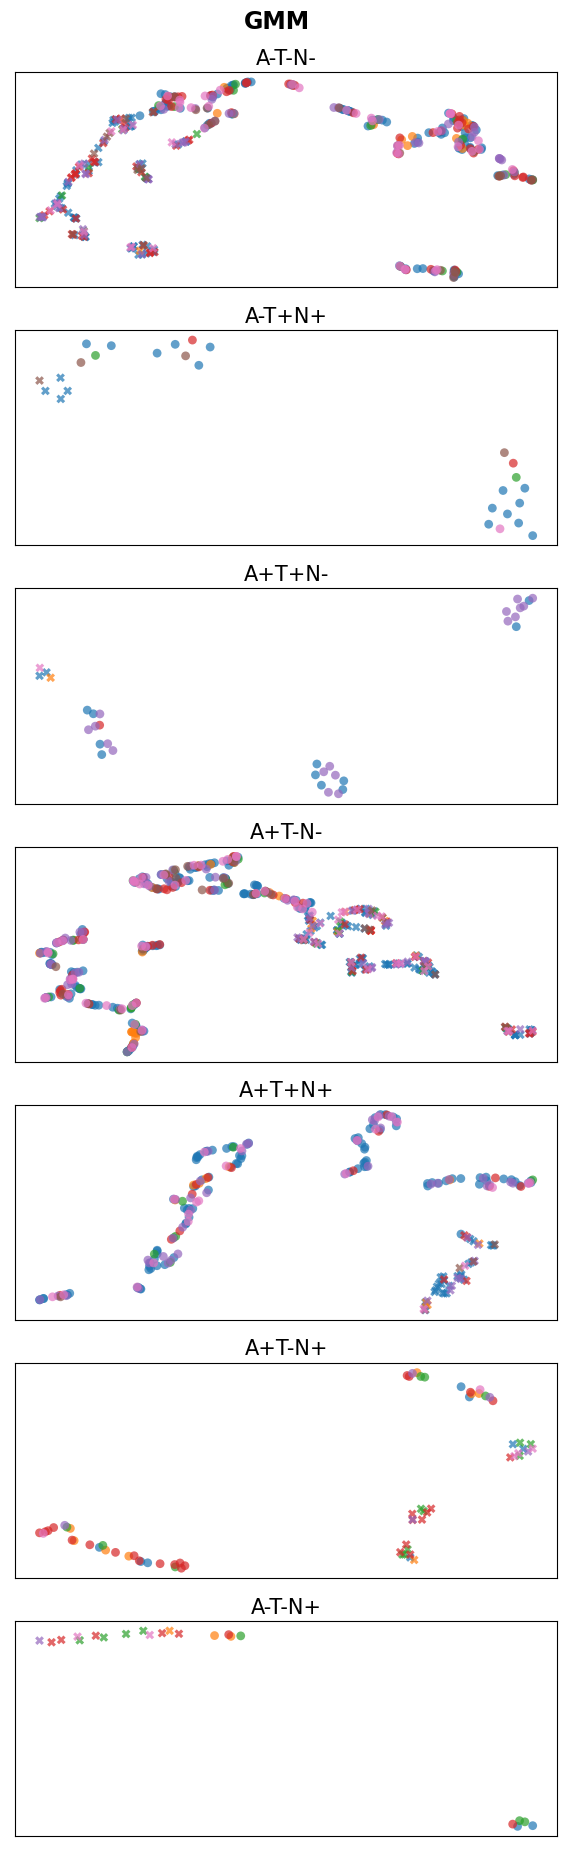

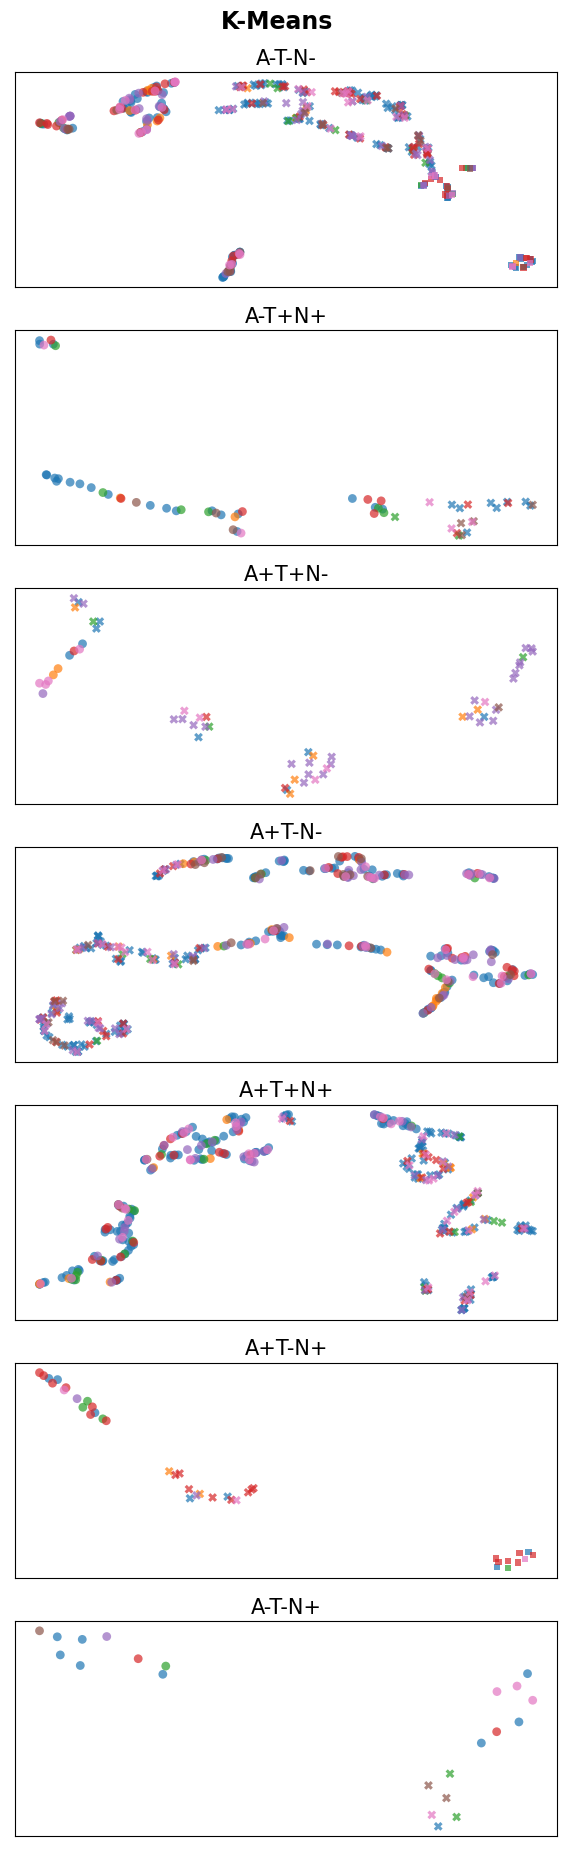

In [93]:
plot_result(embedded_dfs, umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'], 'Cluster_silhouette')

### legend only

In [368]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def plot_result(dfs_dict, list_cohort):
    """"""
    
    color_cohorts = {'ADNI': '#1f77b4', 'NACC': '#d62728', 'JADNI': '#9467bd', 'DOD-ADNI': '#8c564b', 
                     'ARWIBO': '#2ca02c', 'EDSD': '#ff7f0e', 'PharmaCog': '#e377c2'}
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(10, 3 * len(df['ATN'].unique())))
        
        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN', 'Cohort_number', 'Cluster'])], 
                    y=df.loc[df['ATN']==atn_]['Cluster'])

            scatter = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], ax=axes[ind], linewidth=0, 
                                      s=0, style=df.loc[df['ATN']==atn_]['Cluster'], 
                                      hue=df.loc[df['ATN']==atn_]['Cohort'], alpha=0.7, palette=color_cohorts, 
                                      legend=False)
            plt.setp(axes[ind], xticks=[], yticks=[])

            h, l = axes[ind].get_legend_handles_labels()
            # dividing the legend elements into two legend 
            axes[ind].add_artist(axes[ind].legend(handles=h[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
                                                  labels=l[:len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1], 
                                                  fontsize=8, markerscale=1.5, loc='upper right', 
                                                  ncol=len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1, bbox_to_anchor=(1.04,1)))
            axes[ind].add_artist(axes[ind].legend(handles=h[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
                                                  labels=l[1+len(df.loc[df['ATN']==atn_]['Cohort'].unique()):], 
                                                  fontsize=8, markerscale=1.5, loc='center', 
                                                  ncol=len(l)-len(df.loc[df['ATN']==atn_]['Cohort'].unique())+1))
         
            axes[ind].set_title(f'{atn_}', fontsize=15)
            fig.suptitle(f'{met}', fontsize=17, fontweight='bold')
            fig.subplots_adjust(top=0.95)
            
#             plt.savefig(f"../results/umap/paper_plots/{met}_legend.png", dpi=300, bbox_inches='tight')

In [1]:
# plot_result(umap_dfs, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

In [33]:
silho_gmm.astype(float).idxmax(axis=1)

A-T-N-    2.0
A+T-N-    2.0
A+T+N+    2.0
A-T+N+    2.0
A+T+N-    2.0
A+T-N+    2.0
A-T+N-    NaN
A-T-N+    2.0
dtype: float64

In [34]:
silho_km.astype(float).idxmax(axis=1)

A-T-N-    3.0
A+T-N-    2.0
A+T+N+    2.0
A-T+N+    2.0
A+T+N-    2.0
A+T-N+    3.0
A-T+N-    NaN
A-T-N+    2.0
dtype: float64